# Forecast Checker

These notebooks make use of a python package I developed to interpret the performance of a timeseries forecast. 

Typically, when forecasting a timeseries, we want to understand the performance of the e.g. 1, 5, 10, 20-step forecasting performance. We expect forecasting performance to degrade with the forecast length but the measure of a good forecaster over a bad one might be how far ahead we can make reliable forward predictions before the performance degrades to below some threshold.

A common timeseries forecasting approach utilises features common to many natural and socioeconomic processes:

1) The next value depends directly on the previous (auto regressive)

2) Or indirectly responds to some earlier shock (moving average). 

We often also find that timeseries are non-stationary and require differencing or modeling of exogeneous variables.
This notebook uses a custom-built class to generate synthetic data for timeseries modeling based on an ARMA process
with polynomial exogeneous variables.

We then use the Forecast Checker class to evaluate its performance.

## Generate Synthetic Data

In [1]:
#Import dependencies
import Forecast_Checker as fc
import numpy as np
import matplotlib.pylab as plt

In [4]:
#Generate synthetic timeseries process
Nepochs = 1000
forecast_step = 200
synth = fc.generate_synthetic_data(polynomial_exog_coef = [0.0,0.005],
                        Nepochs = Nepochs,
                        forecast_step = forecast_step,
                        synthetic_class = fc.Custom_ARIMA(seed=12345),
                        synthetic_kwargs = {'arparms':[0.75, -0.25],
                                            'maparms':[0.65, 0.35]})
y_test = synth['y_full']
y_test_arima = synth['y_arima']
yex = synth['y_eXog']
eXog_test = synth['eXog_features']

In [5]:
#Perform a model fit and generate predictions 200 time steps ahead
cl2 = fc.Custom_ARIMA(seed=12345)
cl2.fit(y_test[:Nepochs], eXog=eXog_test[:Nepochs, :])
y_pred = cl2.predict(steps=forecast_step, eXog=eXog_test[Nepochs:, :])

In [6]:
# plot the exogeneous and arima components and overlay the prediction
t = np.arange(len(yex))
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(t, y_test_arima, label='arima process')
ax1.set_xlabel('time')
ax1.set_ylabel('arima')

ax1 = fig.add_subplot(312)
ax1.plot(t, yex, label='exogenious time series')
ax1.set_xlabel('time')
ax1.set_ylabel('exog')

ax1 = fig.add_subplot(313)
ax1.plot(t, y_test, label='combined time series')
ax1.plot(t[Nepochs:], y_pred, label='predicted')
ax1.set_xlabel('time')
ax1.set_ylabel('All')
ax1.set_xlim([990,1100])

plt.savefig('arima_test.png')
plt.close()

# Multi-step forecast performance evaluation

Themain purpose of forecast checker is to iteratively chop and blind forecast the input timeseries to approximate the performance correlation coefficient as a function of forecast step. This can be costly in terms of cpu time as we have to continuously refit the model on a new dataset each time points are removed. This process is wrapped up in the handy class below.

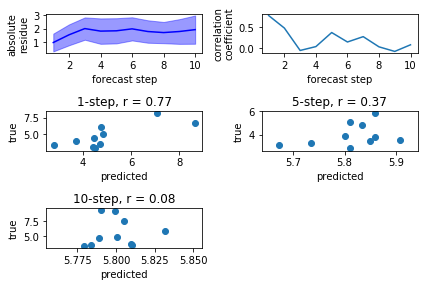

In [8]:
#encode the input timeseries y, eXogeneous variables (None if none) and time series model 
#(must have .fit(y, eXog=) .predict(Nsteps, eXog=) arguments similar to stats models)
ep = fc.evaluate_performance(eXog_test, y_test, model=fc.Custom_ARIMA,
                 kwargs_for_model={'round':False},
                 kwargs_for_fit={'parms': (2, 0, 2)},
                 kwargs_for_predict={'steps': 10},
                 verbose=False, Nsteps=10, Ntests=10)
#perform the evaluation
ep.evaluate()

#correlation vs forecast step saved in evaluation dictionary
correlations = ep.evaluation['correlations']

#plot the correlation performance and show the correlations for the 1, 5 and 10-step forecasts
ep.make_performance_plot(file='test_eval_plot.png',step_plots = [1, 5, 10])

In [11]:
#define 'useful' forecast length as the point where the correlation coefficient drops below e.g. 0.3
useful_forecast_size = np.where(correlations < 0.3)[0][0]
print('This forecast model is predictive for '+str(useful_forecast_size)+' steps.')

This forecast model is predictive for 2 steps.
